# 5. Selecting eligible lapse crosscorrelations

There are two parameters that determine a lapse crosscorrelation's eligibility when it comes to the determination of $t^{(+,\mathrm{app})}_{i,j,k} + t^{(-,\mathrm{app})}_{i,j,k}$. The first is the SNR of the causal and acausal interferometric surface waves. The second is the distance between lapse crosscorrelation's two stations. 

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
tutorial_path = pathlib.Path().resolve()
# Importing the main code.
module_path = os.path.abspath(os.path.join('..', 'src', 'ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ocloc import ProcessingParameters, ClockDrift
from ocloc import read_correlation_file

# Parameters for locating the files where the correlation files.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"

# The reference time is the date of deployment or zero time. 
reference_time = '2014-08-21T00:00:00.000000Z'

# Station info is a file with the stations' metadata
station_file = '/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info'

# Now we describe the processing parameters that will be used for all correlations.
params2 = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

# We load everything into our main object that will handle all the operations.
cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])

No correlation file found for station:O26


# 5.1 SNR threshold

The quality of the measurements (i.e., the $t^{(+,\mathrm{app})}_{i,j,k} + t^{(-,\mathrm{app})}_{i,j,k}$) strongly depends on the signal-to-noise ratio (SNR). If the SNR is too low, the algorithm will struggle to determine the arrival times of the interferometric responses. To see it more clearly let's plot a crosscorrelation with a low SNR.

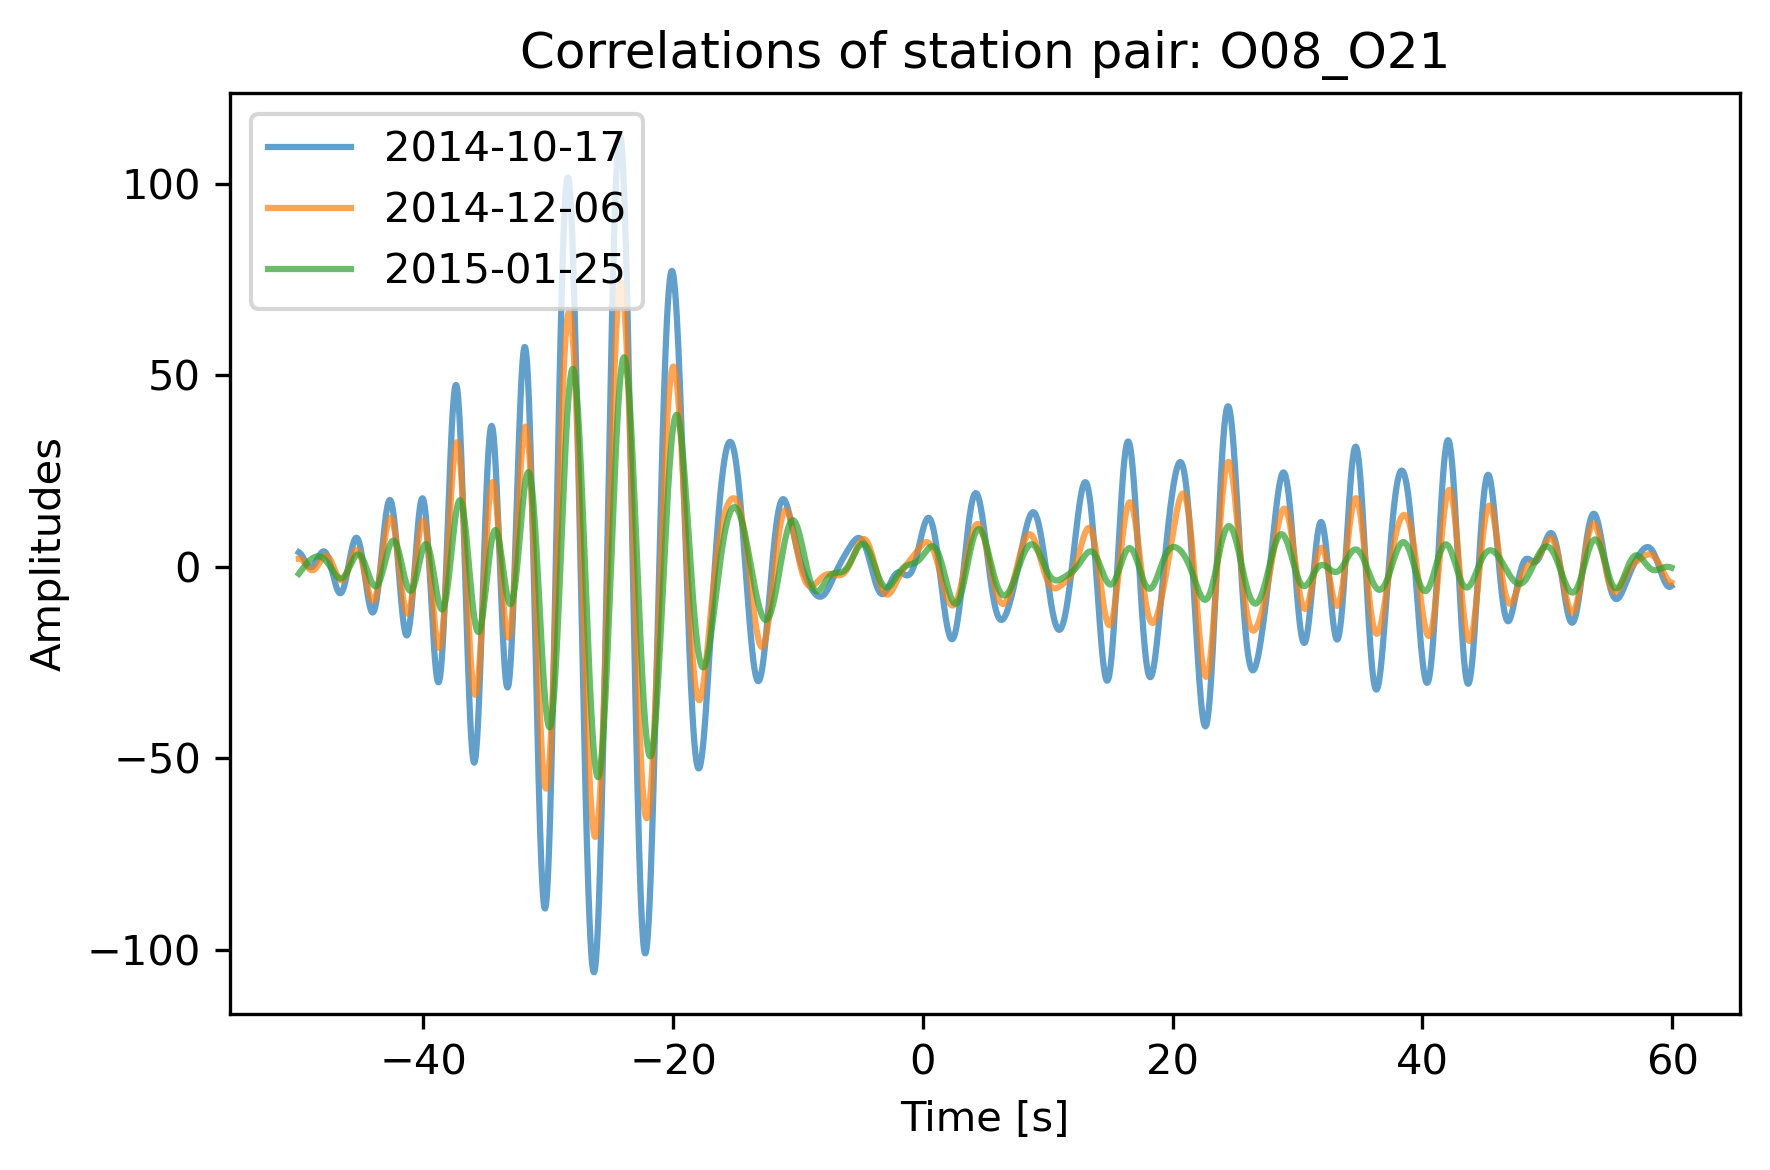

In [3]:
cd.plot_correlations_of_stationpair("O21", "O08", max_t=60)

As you can see, the arrival time of the causal wave is not clear. At least for the frequencies we selected. It is important to check these parameters before the inversion.

# 5.2 Distance threshold

If two stations are too close to each other, the direct surface-wave response at positive time (i.e., the causal arrival) will overlap with the direct surface-wave response at negative time (i.e., the acausal arrival).

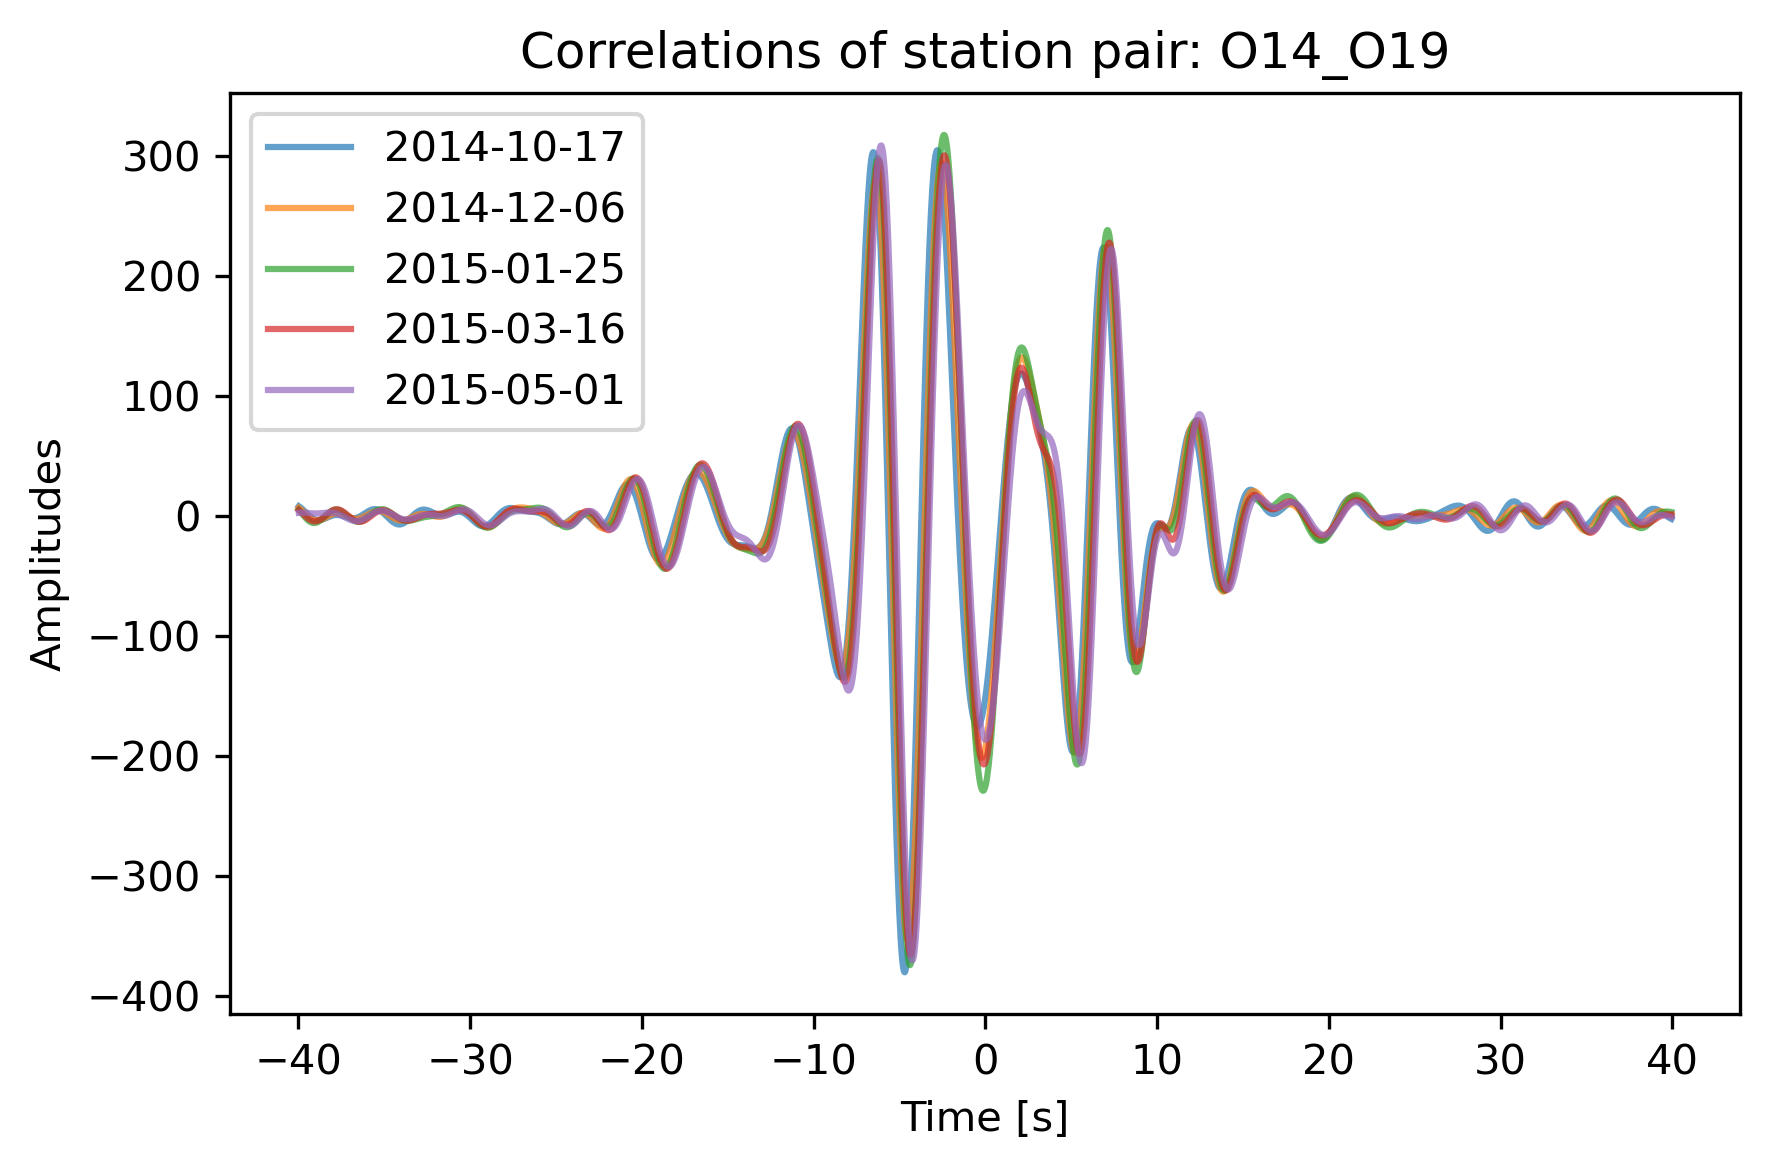

In [4]:
cd.plot_correlations_of_stationpair("O14", "O19", min_t=-40, max_t=40)

# 5.3 Removing stations that have crosscorrelations that are not distributed over time.


After calculating the t_app for all crosscorrelations (`cd.calculate_tapp_4_allcorrelations()`) you can see how well distributed your correlations are over time for a given station. The days_apart argument tells how many days are being grouped together depending on the average time.

For example, let's assume you have two crosscorrelations where their corresponding average dates are October 5 and October 10. If you set `days_apart = 7` the crosscorrelations will be grouped as one correlation period. If you set `days_apart = 3`, then both will form part of the same group.

In [5]:
days_apart = 30
cd.calculate_tapp_4_allcorrelations(days_apart=days_apart)

Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.


You can check the groups of a given station as:

In [6]:
station = cd.get_station("O01")
station.no_corr_per_avg_date

{'2014-10-17': 19, '2014-12-03': 18, '2015-01-19': 16, '2015-03-16': 17}

You can also visualize and compare the # of correlations where the program did not find the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ as:

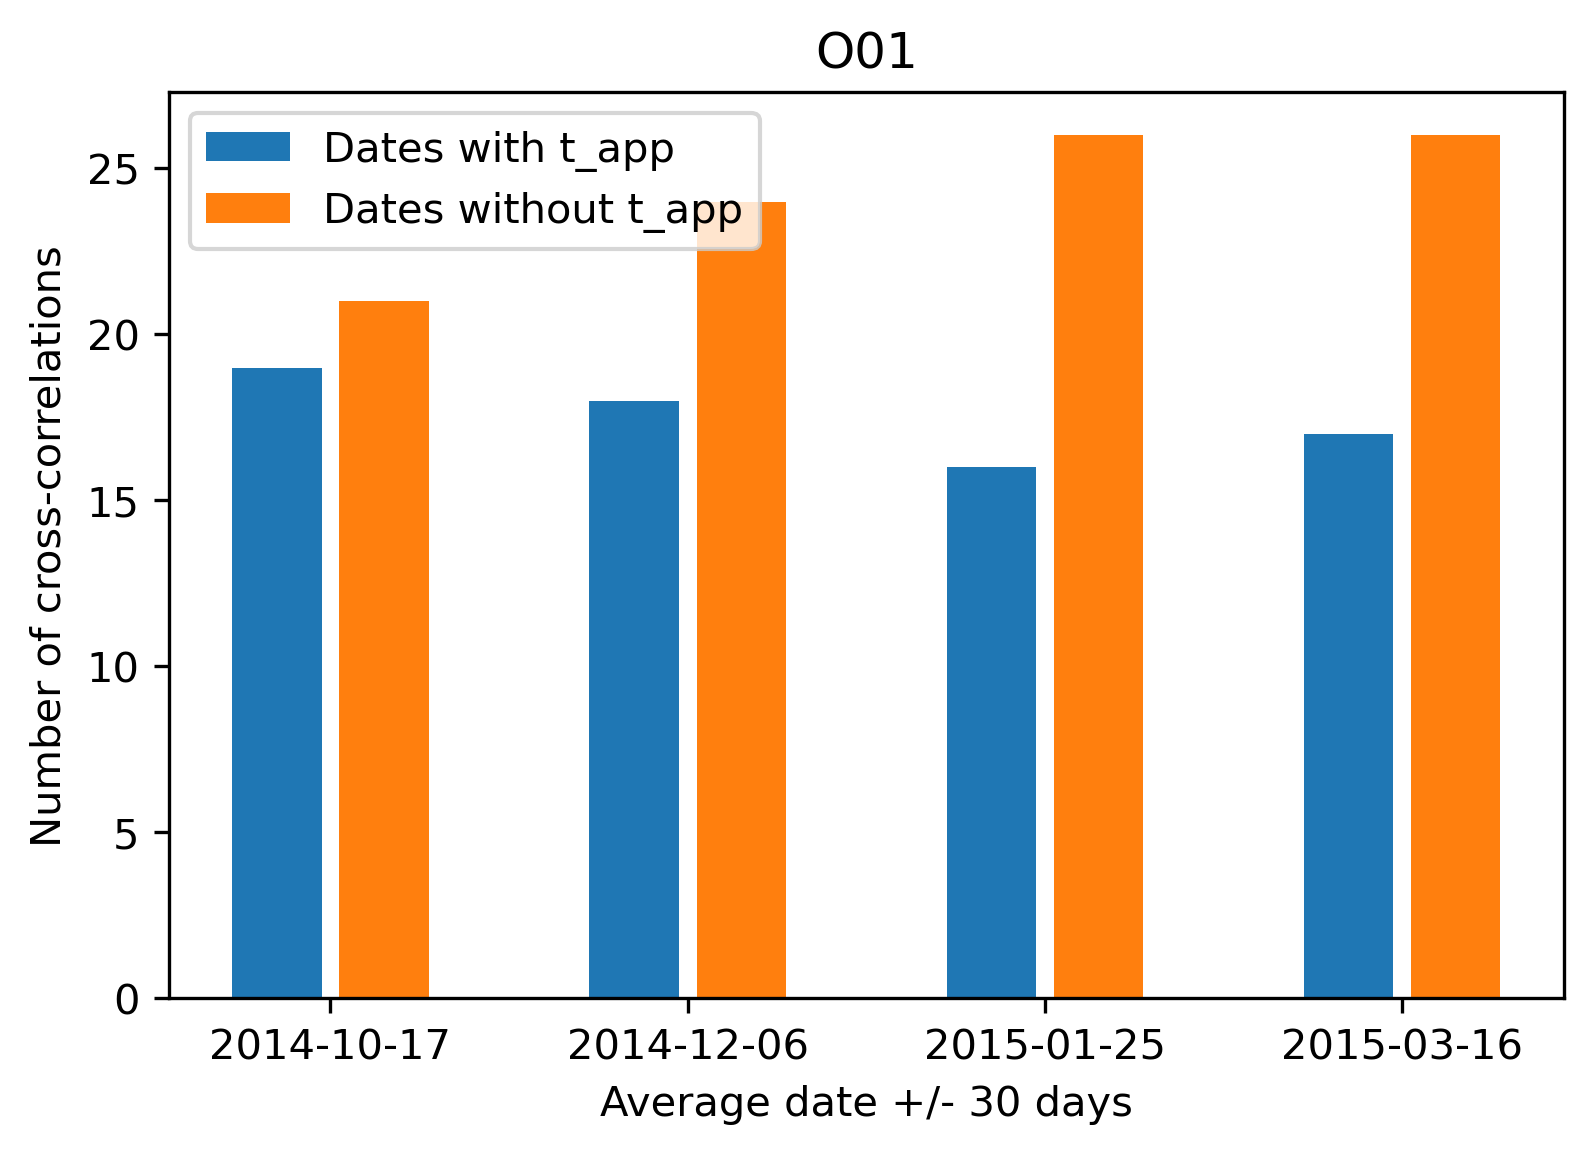

In [7]:
cd.no_corr_per_avg_date(station=station, days_apart=days_apart, plot=True)

It is important to check that we have measures for different time periods because the clock drift depends on the time. Therefore, if we only have points for one single time, then the correction would not be accurate.

For example, let's take a look at the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ of station O01. 

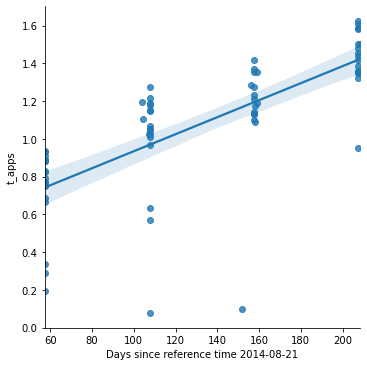

In [8]:
import seaborn as sns
correlations = cd.get_correlations_of_station("O01")

# Get the average dates and calculate number of dates since reference time.
dates = [(c.average_date-cd.reference_time)/86400 for c in correlations]

# Retrieve the computed $t^{+, app}_{i, j} + t^{-, app}_{i, j}$
t_apps = [abs(c.t_app[-1]) for c in correlations]

# Make it a dataframe and use seaborn for plotting nicely
df = pd.DataFrame(data={'dates': dates, 't_apps': t_apps})
sns.lmplot(x="dates", y="t_apps", data=df);
plt.xlabel("Days since reference time " + str(cd.reference_time)[:10])
plt.show()

If concentrate all the measurements to the dates between 90 to 120 days after reference_time, then the many lines can be fitted to the data and it yields incorrect results.

***Note***: The above example includes all the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ for one station. Remember that the $t^{+, app}_{i, j} + t^{-, app}_{i, j}$ is also affected by the time errors of the station with which it is being correlated so a linear regression is not enough to recover the clock errors of a given staiton.

# 5.4 Removing stations that do not have enough crosscorrelations

1. Filter stations that don't have a minimum number of cross-correlations.

2. Filter stations that have all the crosscorrelations concentrated on a single point in time.

3. Filter stations that have few connections to toher stations.

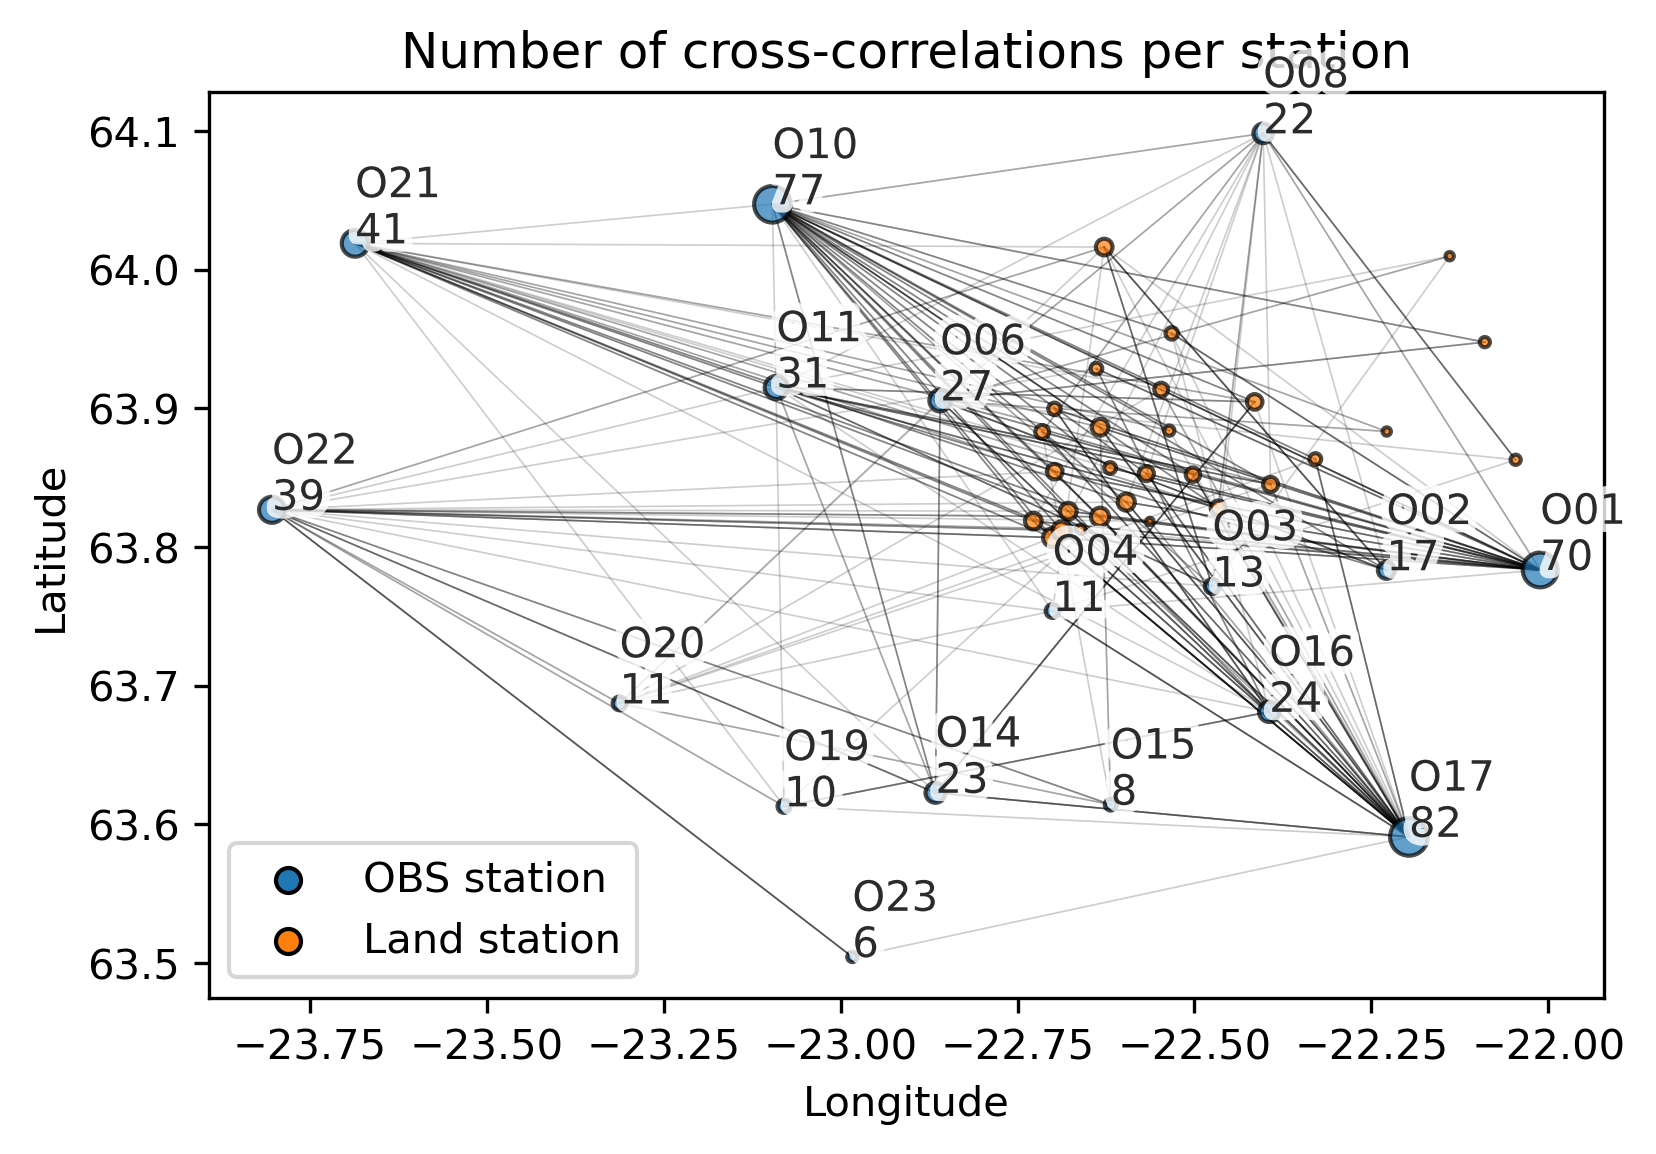

In [9]:
cd.plot_inventory_correlations()

In [10]:
min_number_of_total_correlations = 2
min_number_correlation_periods = 2
min_number_of_stationconnections = 2

# Number of days can be the oldest average_date - earliest average_date
# divided by 10. The 86400 is to convert from seconds to days.
average_dates = [c.average_date for c in cd.correlations]
days_apart = (max(average_dates) - min(average_dates)) / (5 * 86400)

40.11533333333333


In [11]:
cd.filter_stations(min_number_of_total_correlations,
                   min_number_correlation_periods, 
                   min_number_of_stationconnections,
                   days_apart)

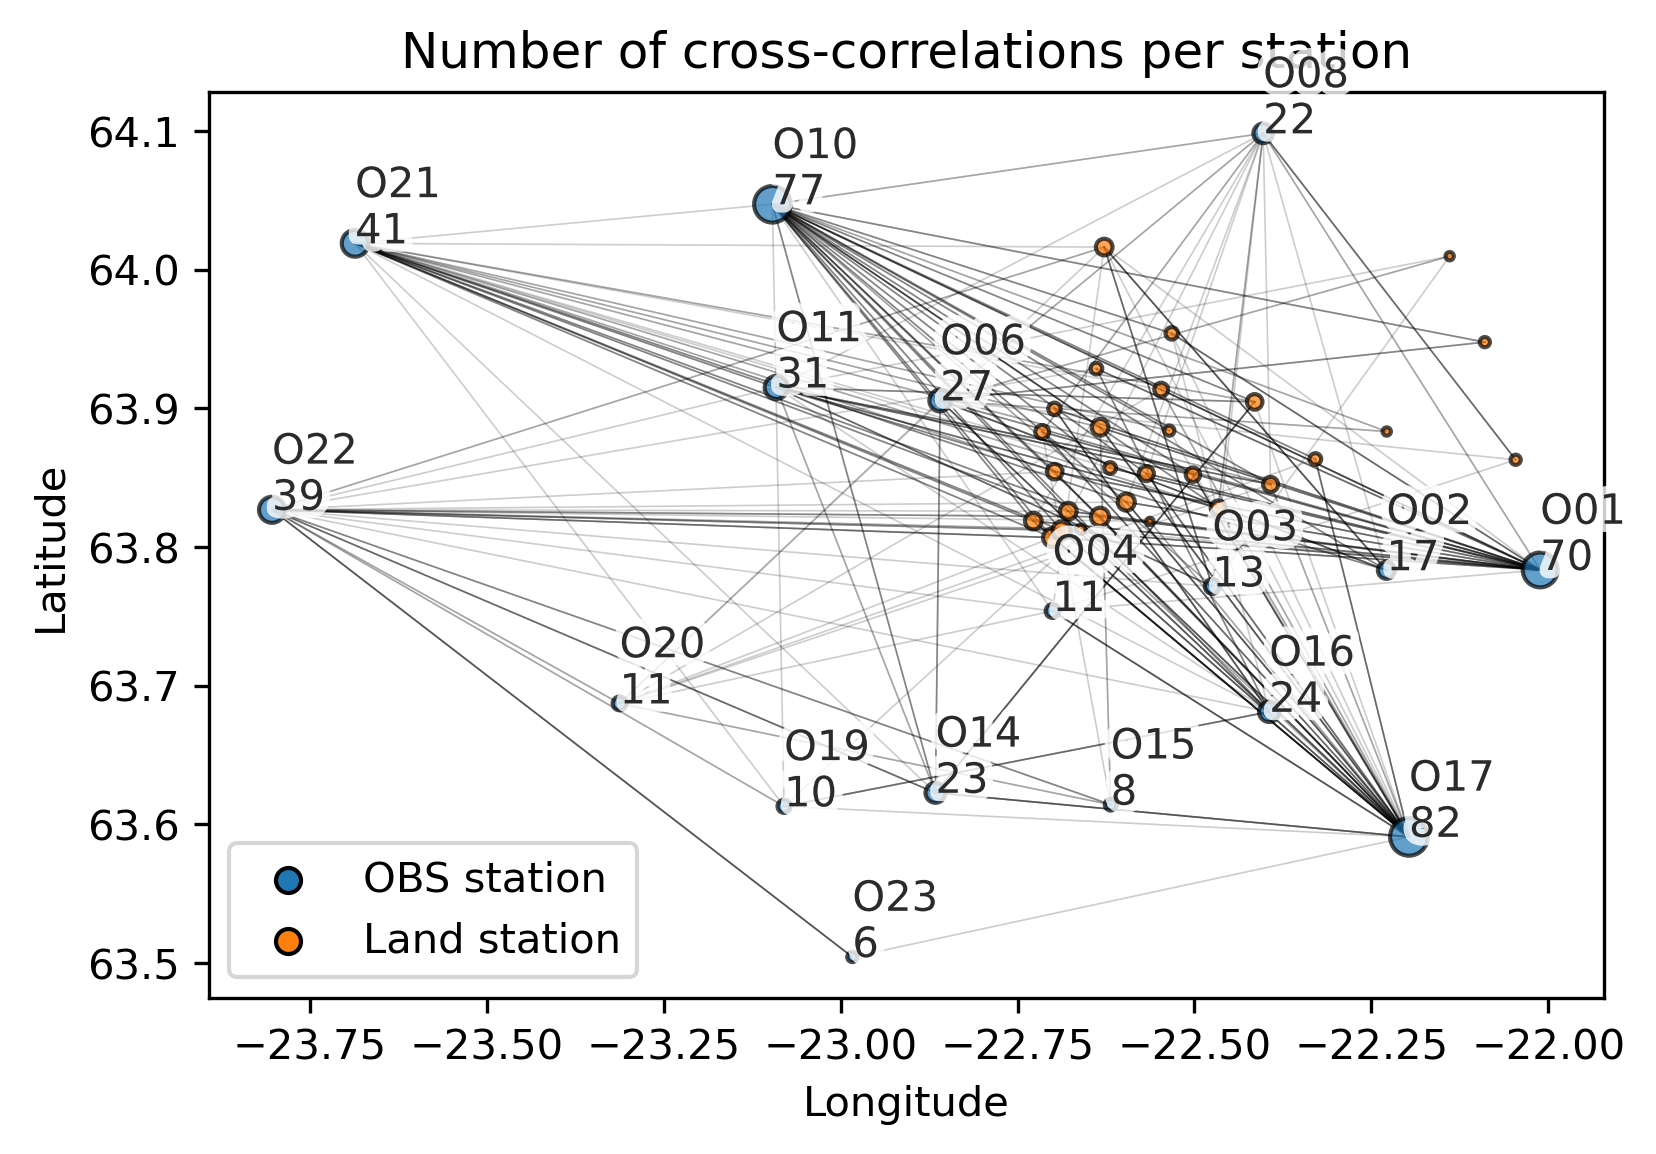

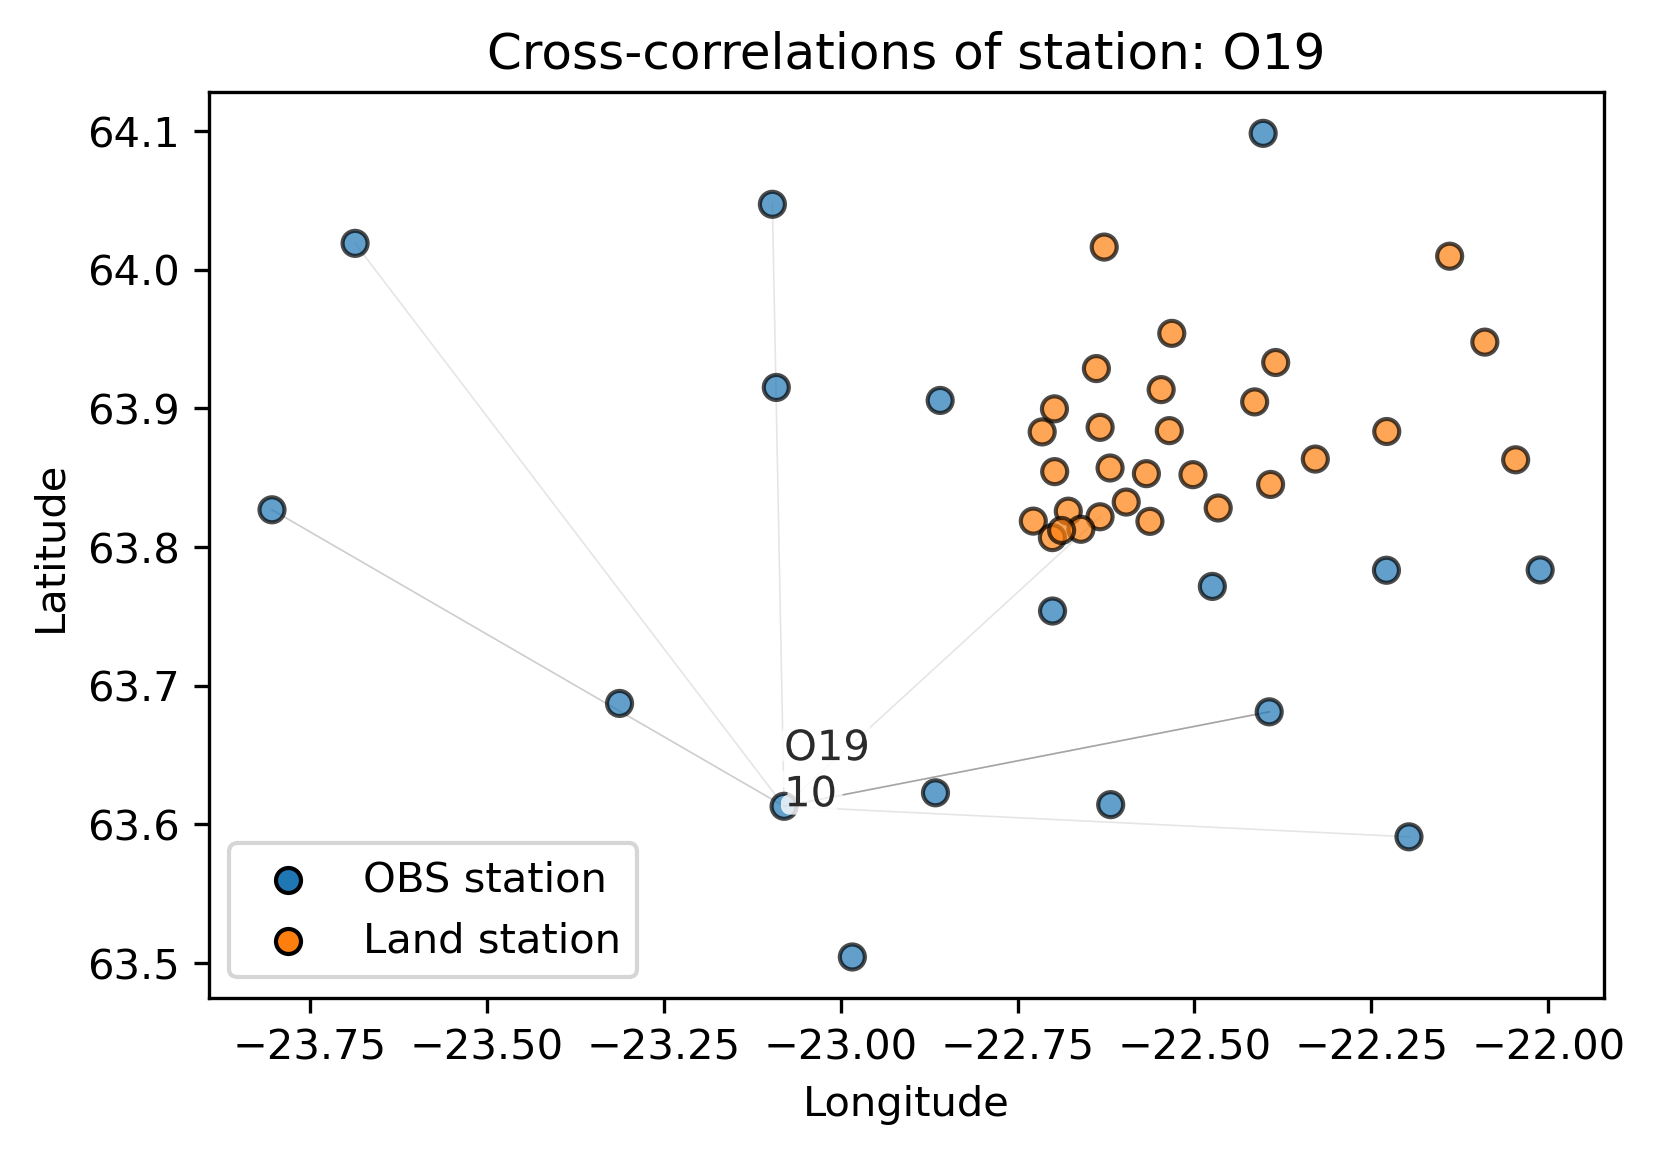

In [12]:
cd.plot_inventory_correlations()
cd.plot_connections_of_station("O19")